# Working with other datasets

We demonstrate how to train a GNN on one of the datasets provided by DeepMind along with the paper [1]. We divide this notebook into three parts:

- Download and preprocess
- Inspect the data
- GNN training

[1] - Sanchez-Gonzalez et al., ["Learning to Simulate Complex Physics with Graph Networks"](https://arxiv.org/abs/2002.09405), ICLR 2020

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt

2024-01-09 13:34:26.356827: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Download and preprocess

The easiest was to download and preprocess the datasets from the GNS paper is by following the instructions in [`gns_data/README.md`](../gns_data/README.md). For our demonstration, we choose the 2D WaterDrop dataset. 

Note: the size of this dataset is around 4.5GB.

In [2]:
!mkdir -p ./datasets
!bash ../gns_data/download_dataset.sh WaterDrop ./datasets

--2023-10-15 01:39:30--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterDrop/metadata.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.186.91, 172.217.18.27, 142.250.186.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.186.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361 [application/octet-stream]
Saving to: ‘./datasets/WaterDrop/metadata.json’

./datasets/WaterDro 100%[===================>]     361  --.-KB/s    in 0s      

2023-10-15 01:39:30 (400 MB/s) - ‘./datasets/WaterDrop/metadata.json’ saved [361/361]

--2023-10-15 01:39:30--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterDrop/train.tfrecord
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.186.91, 142.250.186.187, 142.250.185.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.186.91|:443... connected.
HTTP request sent, awaiti

To avoid conflicting library dependencies, we recommend installing a second virtual environment only for the preprocessing. It will have the lightweight CPU version of TensorFlow, which is needed to open the original datasets.

In [ ]:
!python3 -m venv venv_tf
!venv_tf/bin/pip install tensorflow tensorflow-datasets

Finally, we transform the `*.tfrecord` files to our `*.h5` format. We automatically add two further features to the `metadata.json` file, namely:

- `num_particles_max`: needed for jitability (via padding)
- `periodic_boundary_conditions`: specifying the type of boundary conditions per dimension

Note: This might take a few minutes and will double the space taken by the dataset.

In [4]:
!venv_tf/bin/python ../gns_data/tfrecord_to_h5.py --dataset-path=./datasets/WaterDrop

2023-10-15 01:44:07.609558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 01:44:07.609617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 01:44:07.609667: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 01:44:08.294080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Start conversion of ./datasets/WaterDrop/train.tfrecord to .h5
2023-10-15 01:44:09.073610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


If everything worked fine and you see the `*.h5` files, you can remove the `*.tfrecord` files and the virtual environment.

In [5]:
!rm ./datasets/WaterDrop/*.tfrecord
!rm -r venv_tf

## Inspect the data

Because the number of particles in this dataset varies, we are forced to use `matscipy` as the neighbors search implementation. Matscipy runs on the CPU and can efficiently handle systems with up to milions of particles. To integrate this function into our jit-able codebase, we use `jax.pure_callback()` and pad the non-existing particle entries up to `num_particles_max`.

In [2]:
data_train = lagrangebench.data.H5Dataset(
    split="train", 
    dataset_path="./datasets/WaterDrop",
    name="waterdrop2d",
    nl_backend="matscipy"
)

data_valid = lagrangebench.data.H5Dataset(
    split="valid", 
    dataset_path="./datasets/WaterDrop",
    name="waterdrop2d",
    extra_seq_length=20,
    nl_backend="matscipy"
)
# We can compute the `split_valid_traj_into_n=38` by:
# 1. from [1], Appendix B.1, each trajectory has a length of 1000 steps
# 2. Later, we set `extra_seq_length=20` for the validation loss
# 3. We use 5 historic velocities (or 6 historic positions) 
# => This leads to splitting each training trajectory into 
# 1000 // (20 + 6) = 38 validation instances

print(
    f"This is a {data_train.metadata['dim']}D dataset from {data_train.dataset_path}.\n"
    f"Train frames have shape {data_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val frames have shape {data_valid[0][0].shape} (n_nodes, rollout, xy pos).\n"
    f"And particle types have shape {data_train[0][1].shape} (n_nodes,).\n"
    f"Total of {len(data_train)} train frames and {len(data_valid)} val frames.\n"
)

This is a 2D dataset from ./datasets/WaterDrop.
Train frames have shape (1108, 7, 2) (n_nodes, seq_len, xy pos).
Val frames have shape (1108, 26, 2) (n_nodes, rollout, xy pos).
And particle types have shape (1108,) (n_nodes,).
Total of 995000 train frames and 1140 val frames.



Visualize slices from the first trajectory

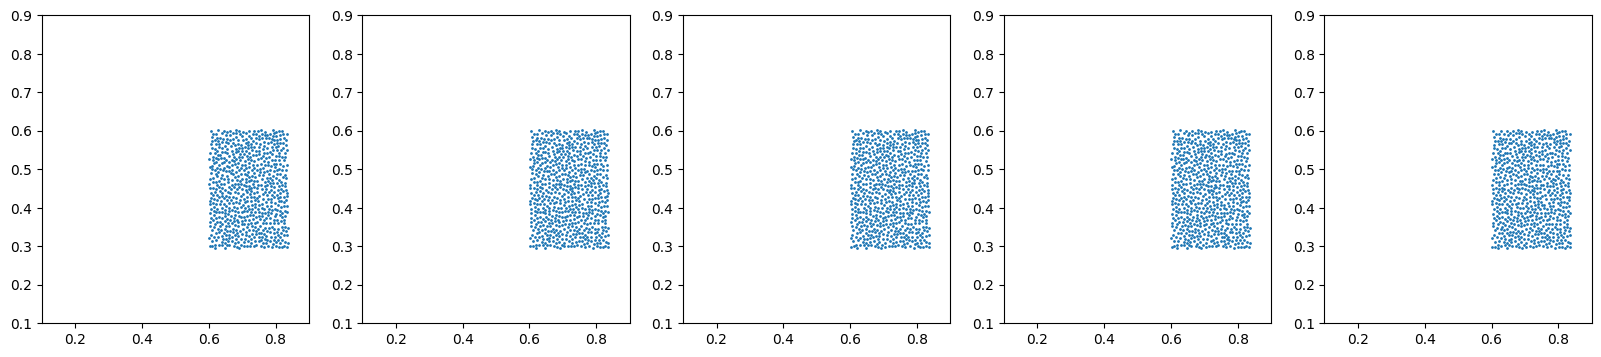

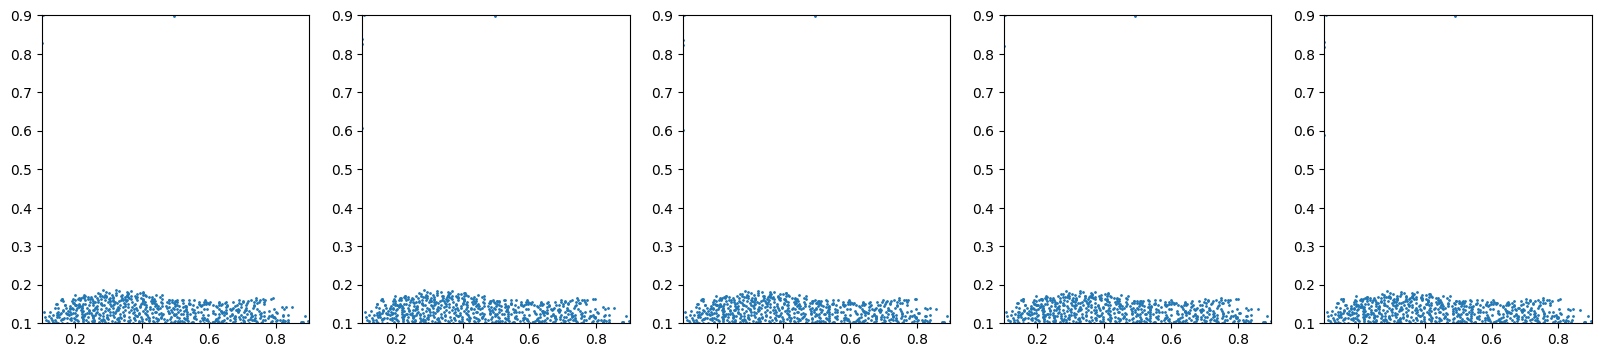

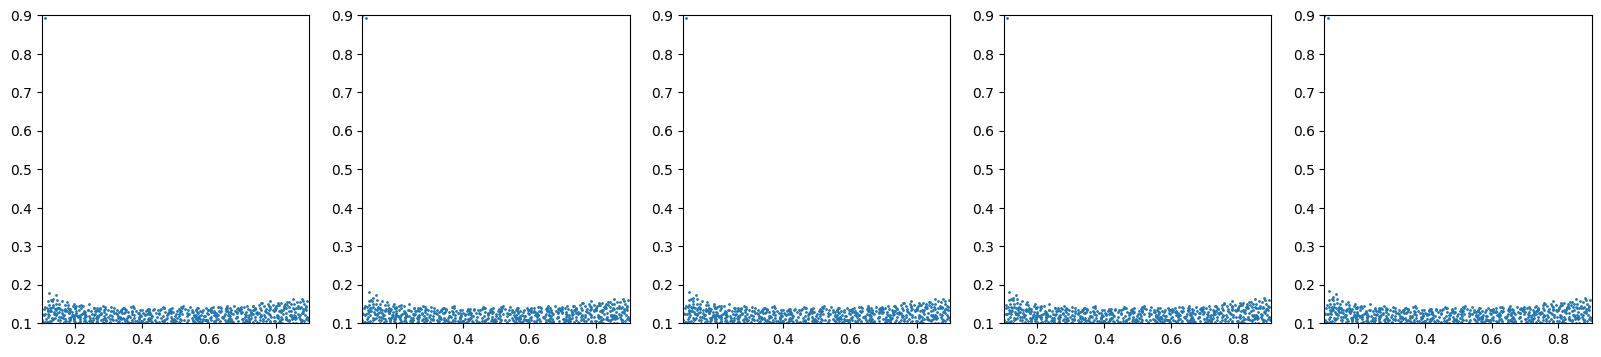

In [3]:

bounds = np.array(data_train.metadata["bounds"])

# from [1], Appendix B.1 we know that the trajectory length is 1000
# If we take indices < 994, we will see samples from the first trajectory
for j in [0, 500, 993]:
    sample = data_train[j]
    
    # visualize 5 consecutive frames
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        mask = sample[1] != -1
        axs[i].scatter(sample[0][mask, i, 0], sample[0][mask, i, 1], s=1)
        axs[i].set_xlim(bounds[0])
        axs[i].set_ylim(bounds[1])
    plt.show()

Here we visualize random frames from the dataset.

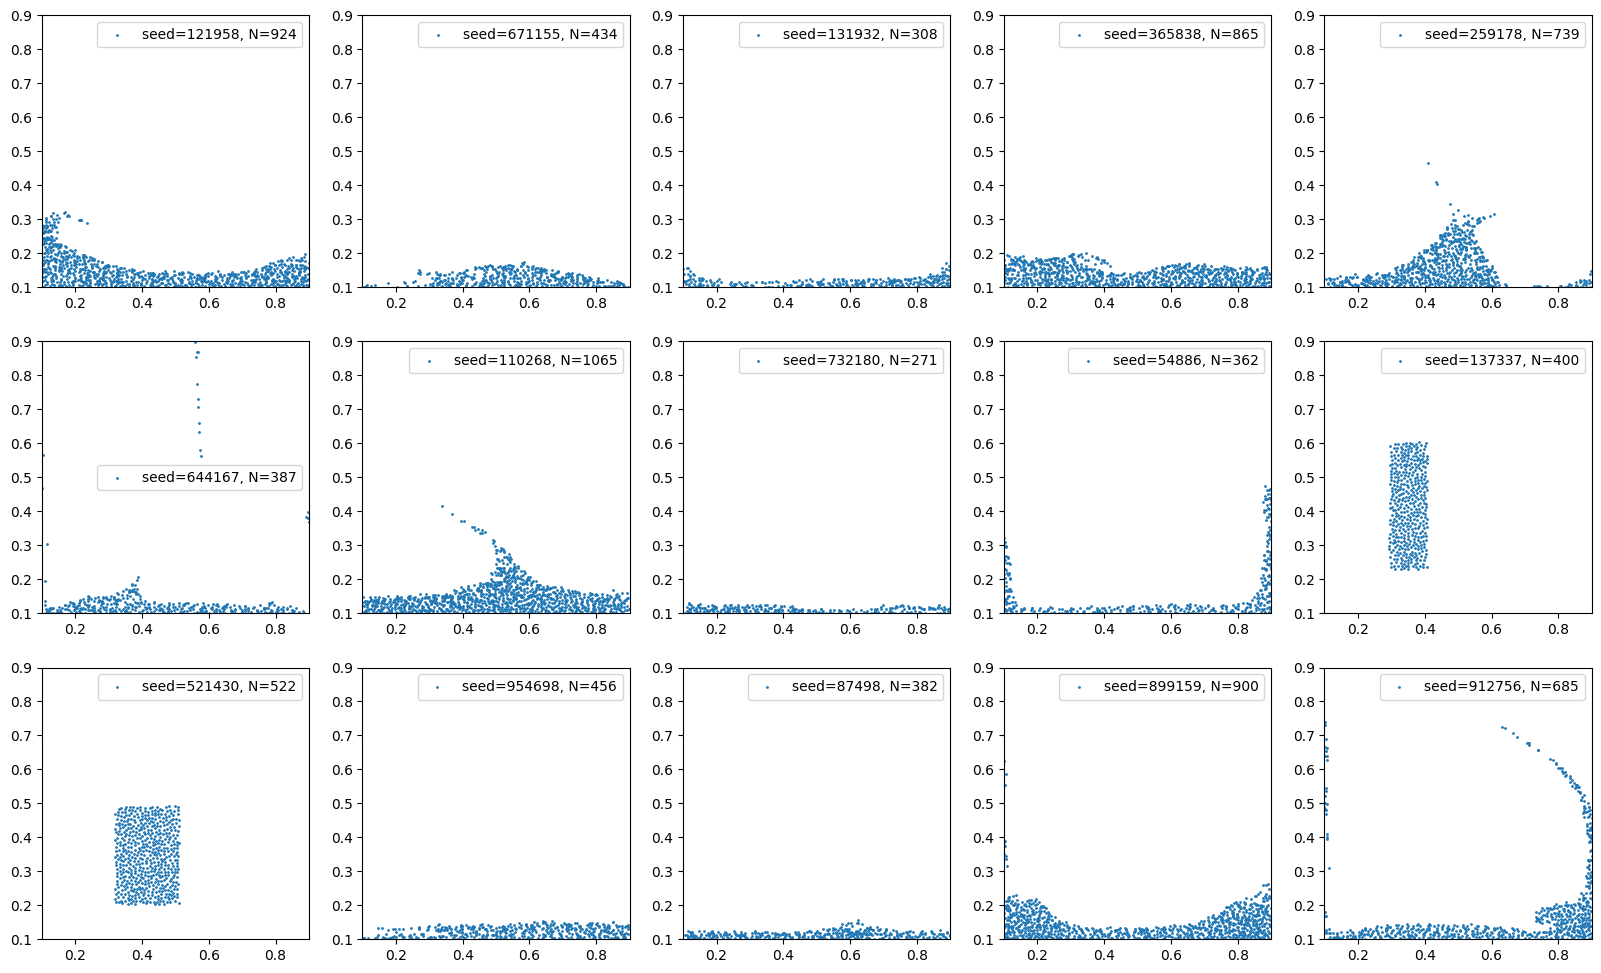

In [4]:
np.random.seed(42)
frame_nums = np.random.randint(0, len(data_train), 15)

# visualize 5 consecutive frames
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for ax, i in zip(axs.flatten(), frame_nums):
    sample = data_train[i]
    mask = sample[1] != -1
    
    ax.scatter(sample[0][mask, 0, 0], sample[0][mask, 0, 1], s=1, 
               label=f"seed={i}, N={np.sum(mask)}")
    ax.legend()
    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])
plt.show()

## GNN training

This works as usual. See [`notebooks/tutorial.ipynb`](./tutorial.ipynb) for more details.

In [5]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=data_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

gns = hk.without_apply_rng(hk.transform_with_state(gns))

noise_std = 3e-4
bounds = np.array(data_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

case = lagrangebench.case_builder(
    box=box,  
    metadata=data_train.metadata,
    input_seq_length=6,
    isotropic_norm=False,
    noise_std=noise_std,
)

trainer = lagrangebench.Trainer(
    model=gns,
    case=case,
    data_train=data_train,
    data_valid=data_valid,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=2,
    lr_start=5e-4,
    log_steps=10,
    eval_steps=50,
)

In [6]:
params, state, _ = trainer(step_max=100)

/home/uppili11/.local/lib/python3.10/site-packages/lagrangebench/case_setup/case.py:153: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos_input = jnp.asarray(sample[0], dtype=dtype)


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 24903497392 bytes.